# Validate effect of IA on spike latency in fitted KGIFs

As of the time of writing (2019.09.03), KGIFs have been fitted to QC-passing 5HT cells using the line search method for $\tau_h$. The models look pretty good, but we need to validate the effect on spike latency. This notebook will make some simple current step simulations to check that at least one of the models shows a clear effect of IA on latency.

In [1]:
import os

os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/home/eharkin/projects/5HTGIF-dev


In [2]:
from copy import deepcopy
import pickle

import matplotlib.pyplot as plt
import numpy as np

# Load fitted models

In [3]:
with open(os.path.join('data', 'models', '5HT', 'serkgifs.lmod'), 'rb') as f:
    mods = pickle.load(f)
    f.close()

In [4]:
mods

# Run simulations

In [5]:
class Simulation(object):
    """Quick struct to hold current step simulations."""
    def __init__(self, I, V, spks, dt):
        self.I = I
        self.V = V
        self.spks = spks
        self.dt = dt
        
    @property
    def t_vec(self):
        return np.arange(0, self.V.shape[0] * self.dt, self.dt)[:self.V.shape[0]]

    @property
    def t_mat(self):
        return np.broadcast_to(self.t_vec[:, np.newaxis], self.V.shape)

In [6]:
curr_step = np.zeros(10000)
curr_step[500:] = 20e-3 # Current injection (pA)

In [7]:
REPS = 20  # Number of replicates for each model.
sims = {
    'baseline': [],
    'IA_KO': []
}

for i, mod in enumerate(mods):
    print('Running simulations for model {} of {}'.format(i, len(mods)))
    V_tmp = []
    spks_tmp = []
    
    # Simulations for baseline mod.
    for rep in range(REPS):
        time, V, eta_sum, V_T, spks = mod.simulate(curr_step, mod.El)
        V_tmp.append(V)
        spks_tmp.append(spks)
    
    sims['baseline'].append(Simulation(
        I = np.broadcast_to(curr_step, (len(V_tmp[0]), len(V))),
        V = np.asarray(V_tmp).T,
        spks = spks_tmp,
        dt = mod.dt
    ))
      
    # Simulations for IA KO mod.
    V_tmp = []
    spks_tmp = []
    mod = deepcopy(mod)
    mod.gbar_K1 = 0
    
    for rep in range(REPS):
        time, V, eta_sum, V_T, spks = mod.simulate(curr_step, mod.El)
        V_tmp.append(V)
        spks_tmp.append(spks)
    
    sims['IA_KO'].append(Simulation(
        I = np.broadcast_to(curr_step, (len(V_tmp[0]), len(V))),
        V = np.asarray(V_tmp).T,
        spks = spks_tmp,
        dt = mod.dt
    ))

del i, mod, rep, time, V, eta_sum, V_T, spks, V_tmp, spks_tmp

Running simulations for model 0 of 12
Running simulations for model 1 of 12
Running simulations for model 2 of 12
Running simulations for model 3 of 12
Running simulations for model 4 of 12
Running simulations for model 5 of 12
Running simulations for model 6 of 12
Running simulations for model 7 of 12
Running simulations for model 8 of 12
Running simulations for model 9 of 12
Running simulations for model 10 of 12
Running simulations for model 11 of 12


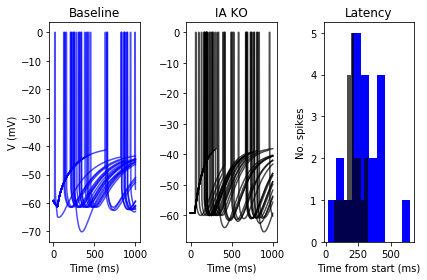

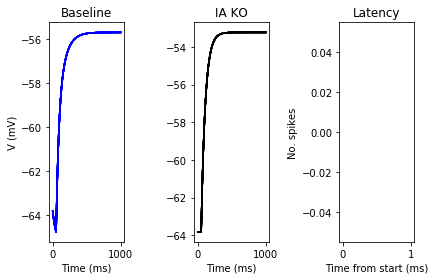

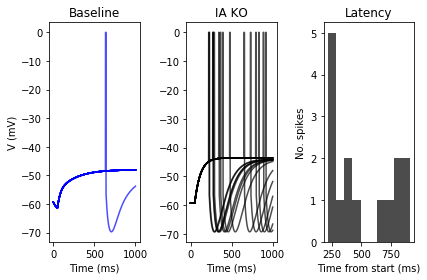

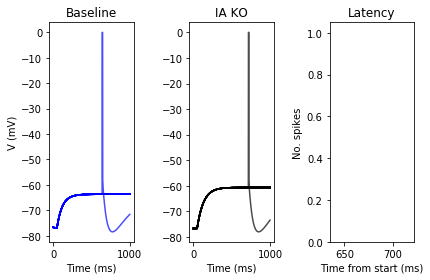

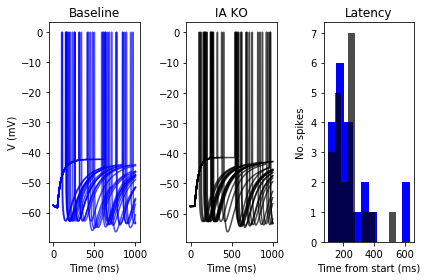

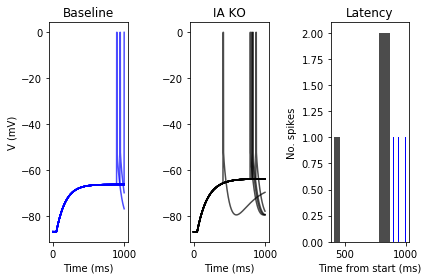

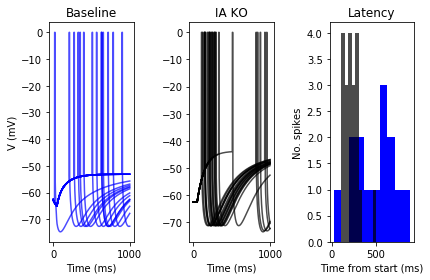

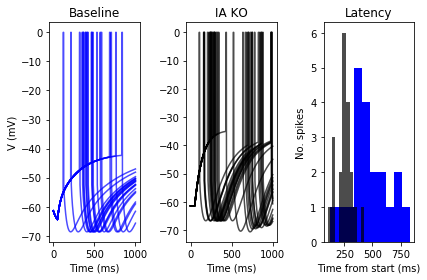

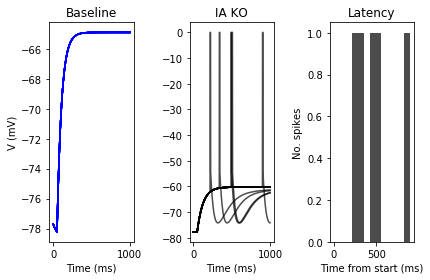

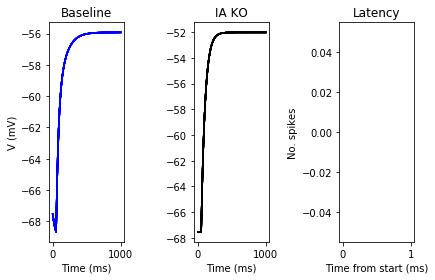

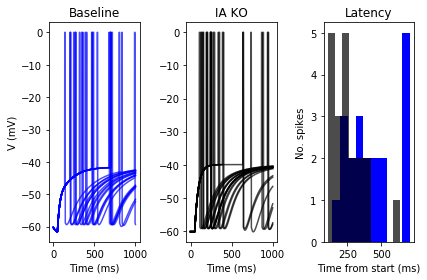

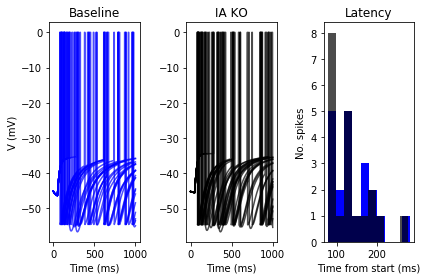

In [8]:
for i in range(len(sims['baseline'])):
    plt.figure()
    
    plt.subplot(131)
    plt.title('Baseline')
    plt.plot(sims['baseline'][i].t_mat, sims['baseline'][i].V, '-', color='blue', alpha=0.7)
    plt.ylabel('V (mV)')
    plt.xlabel('Time (ms)')
    
    plt.subplot(132)
    plt.title('IA KO')
    plt.plot(sims['IA_KO'][i].t_mat, sims['IA_KO'][i].V, 'k-', alpha=0.7)
    plt.xlabel('Time (ms)')
    
    ax = plt.subplot(133)
    ax.set_title('Latency')
    ax.hist([x[0] for x in sims['baseline'][i].spks if len(x) > 0], color='blue')
    ax.hist([x[0] for x in sims['IA_KO'][i].spks if len(x) > 0], color='k', alpha=0.7)
    plt.ylabel('No. spikes')
    plt.xlabel('Time from start (ms)')
    
    plt.tight_layout()
    plt.show()

The baseline condition is the unperturbed fitted models with IA. When IA is removed, the latency to the first spike is increased in several models. In others, there are no spikes for the stimulus I used here, or there is no change. Note that since the models are initialized at $E_l$, $I_A$ is initialized in a partly inactivated state.

**Summary:** $I_A$ has the expected effect on latency in at least some of the fitted models.